In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-af0ef5f5-723e-25e8-7e14-56ef085d5756)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Fraud-Detection Dictionary

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## Importing required libraries



In [ ]:
# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We want our plots to appear in the notebook
%matplotlib inline

## Models
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay # new in Scikit-Learn 1.2+

## Get the dataset

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Fraud.csv"
df = pd.read_csv(file_path)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Removing column that are not required just for fraud detection
# nameOrig and nameDest (doesn't requires as we aren't emphasizing on finding relationship among users)
# isFlaggedFraud (removing as such we have no use of engaging in flagged transactions)

df = df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [ ]:
df.to_csv('fraud_dataset.csv')

In [ ]:
print(f"Number of rows: {len(df)}")
print(f"Number of Columns: {df.shape[1]}")

Number of rows: 6362620
Number of Columns: 8


## Data Exploration (EDA)

In [ ]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [ ]:
# Value comprises with fraud or not (1,0)
df.isFraud.value_counts()

,count
isFraud,
0,6354407
1,8213


In [ ]:
# Normalized value counts
df.isFraud.value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


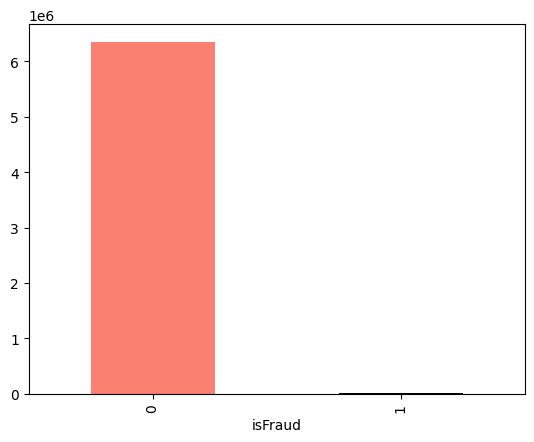

In [ ]:
# Plot the value counts with a bar graph
df.isFraud.value_counts().plot(kind="bar", color=["salmon", "black"]);

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


In [ ]:
# Checking missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values

,0
step,0
type,0
amount,0
oldbalanceOrg,0
newbalanceOrig,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [ ]:
df.tail()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1
6362619,743,CASH_OUT,850002.52,850002.52,0.0,6510099.11,7360101.63,1


## Crosstab of Fraud and type of transaction

In [ ]:
df.type.value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [ ]:
# Compare isFraud column with type column
pd.crosstab(df.isFraud, df.type)

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
isFraud,,,,,
0,1399284,2233384,41432,2151495,528812
1,0,4116,0,0,4097


From this crosstab we can infer that the Chances of Happening Fraud is from `CASH_OUT` and `TRANSFER`

### Making crosstab visual  

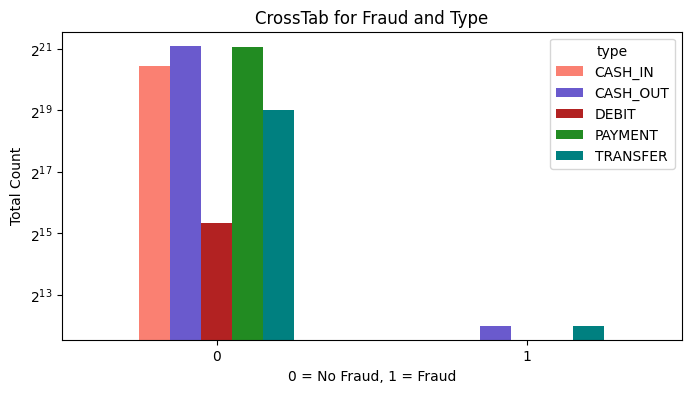

In [ ]:
pd.crosstab(df.isFraud, df.type).plot(kind="bar",
                                    figsize=(8,4),
                                    color=["salmon", "slateblue", 'firebrick', 'forestgreen', 'teal'])
plt.yscale('log', base=2)
plt.title('CrossTab for Fraud and Type')
plt.ylabel('Total Count')
plt.xlabel("0 = No Fraud, 1 = Fraud")
plt.xticks(rotation=0)
plt.show()

### Step vs Type for fraud?

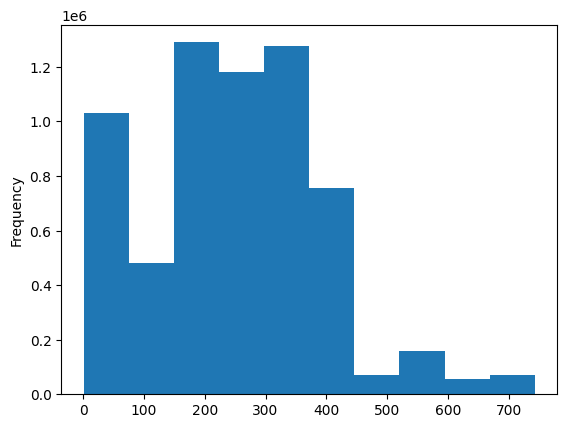

In [ ]:
df.step.plot.hist();

This infer the normal distribution of `step` meaning (Hours) according to the dataset

### Fraud Frequency over Transaction Type

In [ ]:
pd.crosstab(df.type, df.isFraud)

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


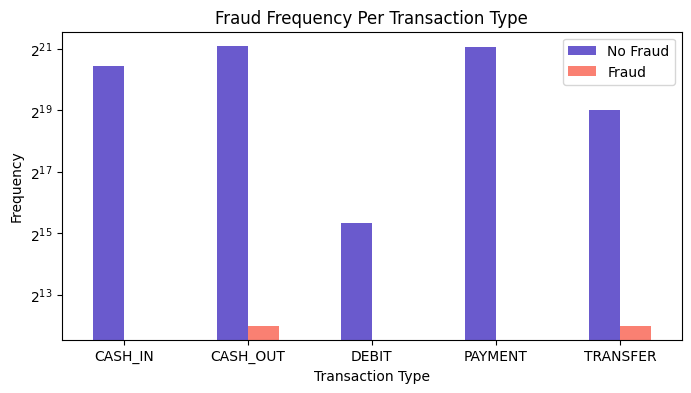

In [ ]:
# Create a new crosstab and base plot
pd.crosstab(df.type, df.isFraud).plot(kind="bar",
                                   figsize=(8,4),
                                   color=["slateblue", "salmon"])

# Add attributes to the plot to make it more readable
plt.title("Fraud Frequency Per Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Frequency")
plt.legend(["No Fraud", "Fraud"])
plt.yscale('log', base=2)
plt.xticks(rotation = 0);

## Correlation between independent variable

In [ ]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


Since `type` is in form of String we can't perform correlation directly as correlation works with numerical data.

Hence first converting `type` into string via `One-Hot Encoding`

In [ ]:
import pandas as pd

df_encoded = pd.get_dummies(df, columns=['type'])
df_encoded.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,False,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,False,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,False,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,False,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,False,False,False,True,False


`Linear Relationship`

In [ ]:
# Find the correlation between our independent variables
corr_matrix = df_encoded.corr()
corr_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.004077,-0.012918,0.002869,0.004926,0.006925
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,-0.009621,-0.004376,-0.023379,-0.197444,0.365896
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.506761,-0.200899,-0.021450,-0.189486,-0.081593
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.527373,-0.210977,-0.021872,-0.193915,-0.087355
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,0.076105,0.086028,0.009347,-0.231455,0.130476
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,0.034988,0.093476,0.006346,-0.238315,0.191701
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,-0.019089,0.011256,-0.002911,-0.025697,0.053869
type_CASH_IN,0.004077,-0.009621,0.506761,0.527373,0.076105,0.034988,-0.019089,1.000000,-0.391047,-0.042987,-0.379522,-0.160535
type_CASH_OUT,-0.012918,-0.004376,-0.200899,-0.210977,0.086028,0.093476,0.011256,-0.391047,1.000000,-0.059625,-0.526422,-0.222672
type_DEBIT,0.002869,-0.023379,-0.021450,-0.021872,0.009347,0.006346,-0.002911,-0.042987,-0.059625,1.000000,-0.057868,-0.024478


Since every thing is now in number let perform:

1. Creating Heatmap
2. Implementing Decision Tree, Random Forest

<Axes: >

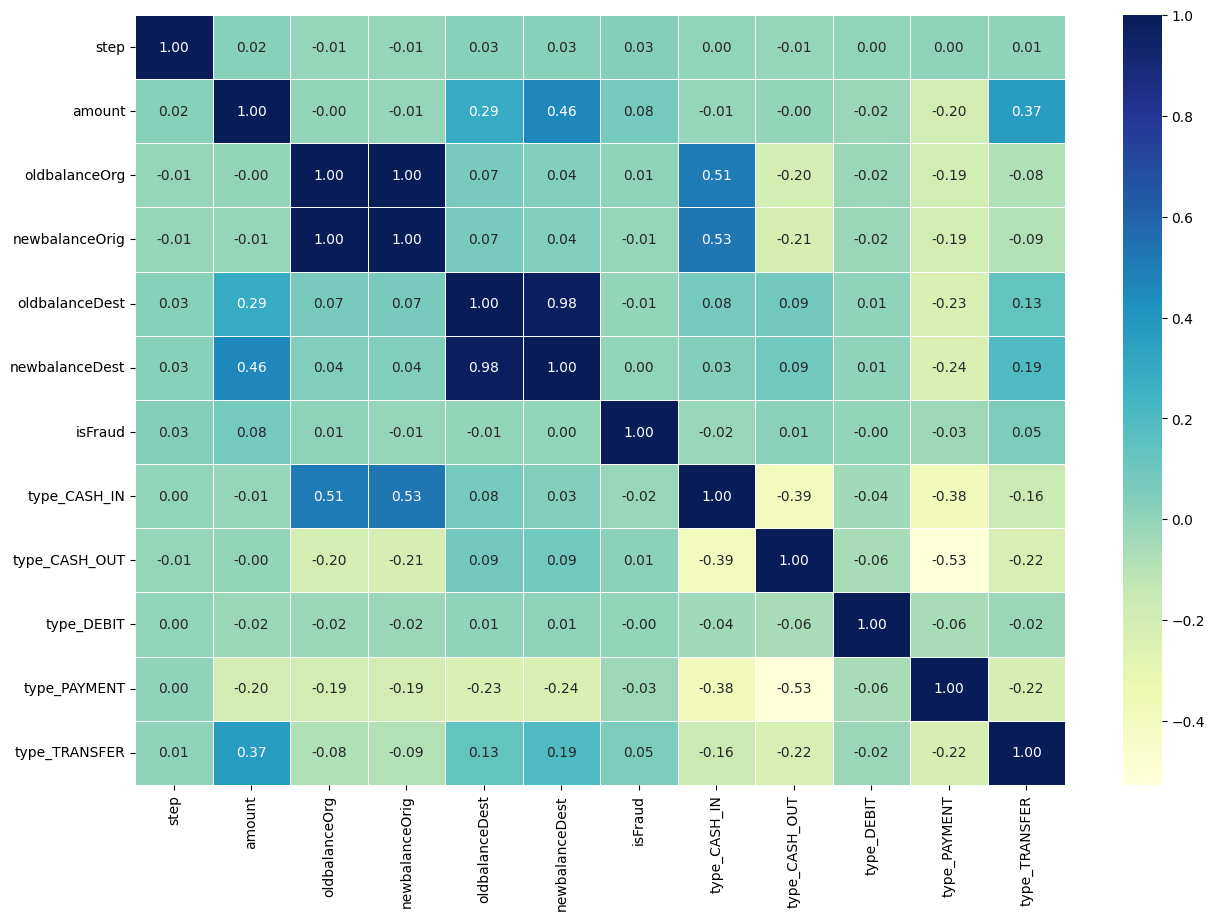

In [ ]:
# HeatMap
plt.figure(figsize=(15, 10))

sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu")

`Non-Linear Relationship`

#### Decision Tree

In [ ]:
from sklearn import tree

X, y = df_encoded.drop("isFraud", axis=1), df_encoded.isFraud
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X, y)

DecisionTreeClassifier(random_state=42)

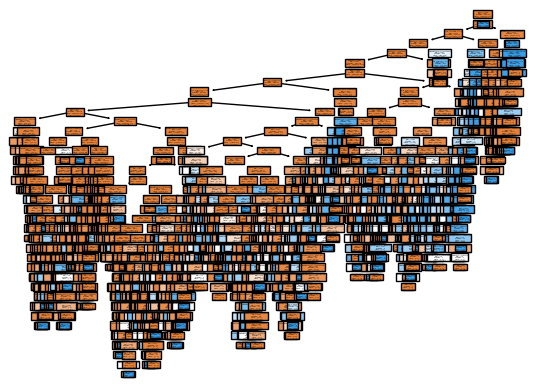

In [ ]:
tree.plot_tree(dt,
               feature_names=X.columns,
               class_names=["Not Fraud", "Fraud"],
               filled=True);

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(dt, X, y, cv=5)
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")

Mean Cross-Validation Score: 0.8035485381808124


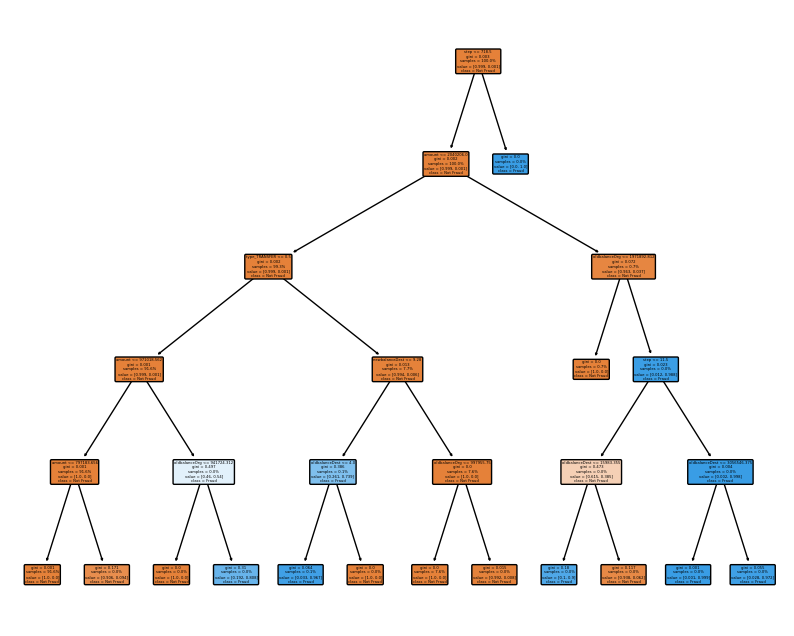

In [ ]:
# for upto depth=5
dt = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X, y)

plt.figure(figsize=(10, 8))
tree.plot_tree(dt,
               feature_names=X.columns,
               class_names=["Not Fraud", "Fraud"],
               rounded=True,
               filled=True,
               proportion=True);
plt.show()

In [ ]:
from sklearn.tree import export_text

# Export the decision tree in text format
tree_rules = export_text(dt, feature_names=list(X.columns))
print(tree_rules)

|--- step <= 718.50
|   |--- amount <= 2040206.00
|   |   |--- type_TRANSFER <= 0.50
|   |   |   |--- amount <= 971018.56
|   |   |   |   |--- amount <= 797183.66
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- amount >  797183.66
|   |   |   |   |   |--- class: 0
|   |   |   |--- amount >  971018.56
|   |   |   |   |--- oldbalanceOrg <= 941724.31
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- oldbalanceOrg >  941724.31
|   |   |   |   |   |--- class: 1
|   |   |--- type_TRANSFER >  0.50
|   |   |   |--- newbalanceDest <= 9.28
|   |   |   |   |--- oldbalanceDest <= 4.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- oldbalanceDest >  4.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- newbalanceDest >  9.28
|   |   |   |   |--- oldbalanceOrg <= 997955.75
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- oldbalanceOrg >  997955.75
|   |   |   |   |   |--- class: 0
|   |--- amount >  2040206.00
|   |   |--- oldbalanceOrg <= 1971892.81
|   |   |   |--- clas

## Model

In [ ]:
df_encoded.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,False,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,False,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,False,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,False,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,False,False,False,True,False


In [ ]:
X = df_encoded.drop("isFraud", axis=1)
y = df_encoded.isFraud.values

In [ ]:
# Splitting the dataset into training and testing
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(5090096, 1272524, 5090096, 1272524)

For this problem via https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html

The appropriate model algorithm to use is `SGD`: Stochastic Gradient Descent

In [ ]:
# Using SGD algorithm
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5)

## Predictions

In [ ]:
# Make preidctions on test data
y_preds = model.predict(X_test)
y_preds

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
model.coef_

array([[-3.04327449e+04, -5.38610346e+04,  5.54124733e+04,
        -6.33700501e+04, -5.65341580e+01, -1.49041905e+03,
        -2.46745947e-01, -1.38501486e+01, -9.77554008e-02,
        -1.12147762e+02, -1.33431407e+00]])

## Evaluating a classification model

### ROC Curve and AUC Scores

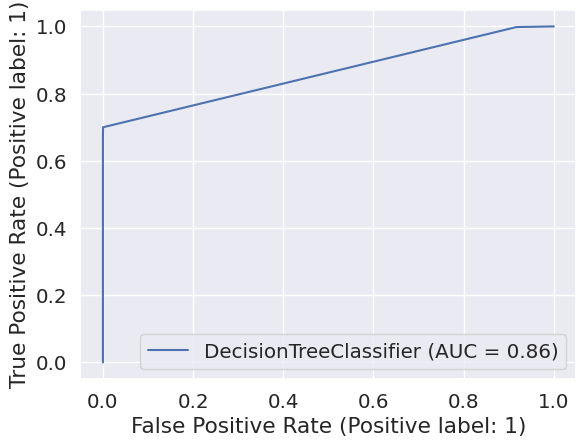

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(estimator=dt,
                               X=X_test,
                               y=y_test);

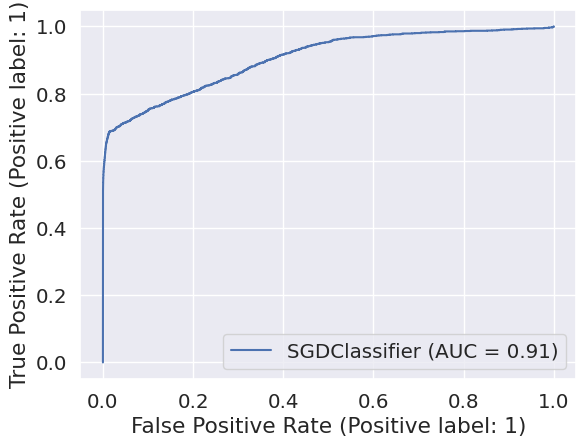

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(estimator=model,
                               X=X_test,
                               y=y_test);

### Confusion Matrix

In [ ]:
# Display confusion matrix
print(confusion_matrix(y_test, y_preds))

[[1265756    5148]
 [    632     988]]


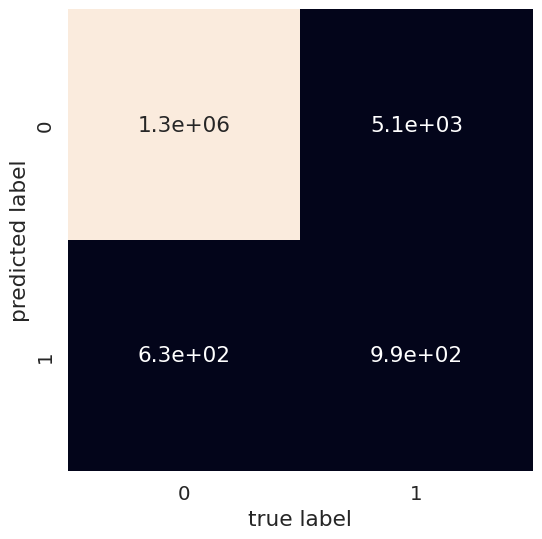

In [ ]:
# Visualizing Confusion Matri
import seaborn as sns
sns.set(font_scale=1.3)

def plot_confusion_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")

plot_confusion_mat(y_test, y_preds)

### Classification Report

In [ ]:
# Show classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.16      0.61      0.25      1620

    accuracy                           1.00   1272524
   macro avg       0.58      0.80      0.63   1272524
weighted avg       1.00      1.00      1.00   1272524



## Answering The Questions

### 1. Data Cleaning


CHecking The Presence of the missing value and performaing action regarding it.

```python
# Checking missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values
```

For Coorelation using coorelation matrix between the varibale
```python
# Find the correlation between our independent variables
corr_matrix = df_encoded.corr()
corr_matrix
```

### 2. Model

The model used for fraud detection is a Stochastic Gradient Descent (SGD) classifier. It’s an efficient classifier for large datasets due to its capability of handling large-scale data. https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html

Here's a summary of the model:

* `Algorithm`: Stochastic Gradient Descent

* `Loss Function`: Hinge loss, commonly used for classification problems.

* `Penalty`: L2 regularization to prevent overfitting.

* `Iteration`: Limited to 5 iterations to avoid overfitting and ensure convergence.


SGDClassifier is known for its efficiency and scalability in large datasets, making it suitable for fraud detection tasks with large volumes of transaction data.

```python
# Using SGD algorithm
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
model.fit(X, y)
```

### 3. Variable Selection

Variables were selected based on their relevance to detecting fraudulent transactions.
The `nameOrig` and `nameDest` columns were dropped as they don't contribute directly to the prediction of fraud but rather represent transaction relationships. The `isFlaggedFraud` column was also removed as it was not useful for our analysis.

The remaining features such as `amount`, `step`, and `transaction` types were retained as they directly relate to transaction characteristics that might indicate fraud.

Due to time constraint intentially dropped the logic for olbalance, newbalance columns. Further analysis over this can also improve the model.

However, model is checked over steps, amount, and transactions.


### 4. Model Performance

To evaluate the model, various metrics were used:

`ROC Curve` and `AUC Scores`: To visualize the trade-off between true positive rate and false positive rate.

`Confusion Matrix`: To evaluate the model's performance in terms of true positives, false positives, true negatives, and false negatives.

`Classification Report`: Provides precision, recall, and F1-score for both classes (fraudulent and non-fraudulent).

<br>

ROC Curve:
```python
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(estimator=model,
                               X=X_test,
                               y=y_test);
```
With AUC value of 0.91

<br>

Confusion Matrix:
```python
# Display confusion matrix
print(confusion_matrix(y_test, y_preds))
```
```Output
[[1265756    5148]
 [    632     988]]
```

<br>

Classification Report:
```python
# Show classification report
print(classification_report(y_test, y_preds))
```
```Output
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.16      0.61      0.25      1620

    accuracy                           1.00   1272524
   macro avg       0.58      0.80      0.63   1272524
weighted avg       1.00      1.00      1.00   1272524
```

### 5. Key Factors Predicting Fraudulent Transactions

Key factors include:

`Transaction Amount`: Higher amounts may be more likely to be fraudulent.

`Transaction Type`: Transactions categorized as `CASH_OUT` and `TRANSFER` are more commonly associated with fraud.

`Transaction Step`: The distribution of fraud across different time steps might provide insights into patterns. The Normal Distribution dictates that Steps between around `150-350` where fraudities happend.

<br>

Crosstab of fraud vs. transaction type
```
type	CASH_IN	CASH_OUT	  DEBIT	PAYMENT	TRANSFER
isFraud
0	    1399284	2233384	  41432	2151495	528812
1	    0	      4116	      0	    0	      4097
```
<br>

Distribution of fraud across transaction amounts and steps
```python
df.step.plot.hist();
```

### 6. Sense of Factors

These factors make sense:

`Amount`: Large transactions are more likely to be fraudulent due to higher potential gains.

`Type`: Certain transaction types (e.g., CASH_OUT, TRANSFER) are more prone to fraud as they involve moving funds out of the account.

`Step`: Understanding the time distribution of fraud can help identify patterns and anomalies.


### 7. Prevention Measures

To prevent fraud, consider the following measures:

`Enhanced Monitoring`: Implement real-time transaction monitoring systems for high-risk transactions.

`Threshold Limits`: Set limits on transaction amounts and flag transactions exceeding these limits for manual review.

`Behavioral Analysis`: Use machine learning models to analyze transaction patterns and detect anomalies.

`User Verification`: Implement multi-factor authentication for transactions above a certain threshold.


### 8. Evaluating Prevention Actions

To determine if the implemented actions are effective:

`Monitor Fraud Rates`: Compare fraud rates before and after implementation.

`Review Alerts and False Positives`: Assess the number and accuracy of flagged transactions.

`Continuous Improvement`: Regularly update models and thresholds based on new patterns and emerging fraud techniques.

`Feedback Loop`: Incorporate feedback from fraud detection teams to refine and enhance the system.

* Comparison of fraud rates before and after
* Analysis of alerts and false positives


refer: https://github.com/kanish-h-h/fraud-detection